In [7]:
import sys
# sys.path.append('../')
from pycore.tikzeng import *
from pycore.blocks import *
import subprocess

In [5]:
# defined your arch
arch = [
    to_head( '..' ),
    to_cor(),
    to_begin(),
    to_Conv("conv1", 512, 64, offset="(0,0,0)", to="(0,0,0)", height=64, depth=64, width=2 ),
    to_Pool("pool1", offset="(0,0,0)", to="(conv1-east)"),
    to_Conv("conv2", 128, 64, offset="(1,0,0)", to="(pool1-east)", height=32, depth=32, width=2 ),
    to_connection( "pool1", "conv2"), 
    to_Pool("pool2", offset="(0,0,0)", to="(conv2-east)", height=28, depth=28, width=1),
    to_SoftMax("soft1", 10 ,"(3,0,0)", "(pool1-east)", caption="SOFT"  ),
    to_connection("pool2", "soft1"),    
    to_end()
    ]

namefile = 'test'
out = to_generate(arch, namefile + '.tex' )
subprocess.run(['pdflatex', namefile+'.tex'])


CompletedProcess(args=['pdflatex', 'test.tex'], returncode=0)

In [11]:
arch = [ 
    to_head('..'), 
    to_cor(),
    to_begin(),
    
    #block-001
    to_ConvConvRelu( name='ccr_b1', s_filer=500, n_filer=(64,64), offset="(0,0,0)", to="(0,0,0)", width=(2,2), height=40, depth=40  ),
    to_Pool(name="pool_b1", offset="(0,0,0)", to="(ccr_b1-east)", width=1, height=32, depth=32, opacity=0.5),
    
    *block_2ConvPool( name='b2', botton='pool_b1', top='pool_b2', s_filer=256, n_filer=128, offset="(1,0,0)", size=(32,32,3.5), opacity=0.5 ),
    *block_2ConvPool( name='b3', botton='pool_b2', top='pool_b3', s_filer=128, n_filer=256, offset="(1,0,0)", size=(25,25,4.5), opacity=0.5 ),
    *block_2ConvPool( name='b4', botton='pool_b3', top='pool_b4', s_filer=64,  n_filer=512, offset="(1,0,0)", size=(16,16,5.5), opacity=0.5 ),

    #Bottleneck
    #block-005
    to_ConvConvRelu( name='ccr_b5', s_filer=32, n_filer=(1024,1024), offset="(2,0,0)", to="(pool_b4-east)", width=(8,8), height=8, depth=8, caption="Bottleneck"  ),
    to_connection( "pool_b4", "ccr_b5"),

    #Decoder
    *block_Unconv( name="b6", botton="ccr_b5", top='end_b6', s_filer=64,  n_filer=512, offset="(2.1,0,0)", size=(16,16,5.0), opacity=0.5 ),
    to_skip( of='ccr_b4', to='ccr_res_b6', pos=1.25),
    *block_Unconv( name="b7", botton="end_b6", top='end_b7', s_filer=128, n_filer=256, offset="(2.1,0,0)", size=(25,25,4.5), opacity=0.5 ),
    to_skip( of='ccr_b3', to='ccr_res_b7', pos=1.25),    
    *block_Unconv( name="b8", botton="end_b7", top='end_b8', s_filer=256, n_filer=128, offset="(2.1,0,0)", size=(32,32,3.5), opacity=0.5 ),
    to_skip( of='ccr_b2', to='ccr_res_b8', pos=1.25),    
    
    *block_Unconv( name="b9", botton="end_b8", top='end_b9', s_filer=512, n_filer=64,  offset="(2.1,0,0)", size=(40,40,2.5), opacity=0.5 ),
    to_skip( of='ccr_b1', to='ccr_res_b9', pos=1.25),
    
    to_ConvSoftMax( name="soft1", s_filer=512, offset="(0.75,0,0)", to="(end_b9-east)", width=1, height=40, depth=40, caption="SOFT" ),
    to_connection( "end_b9", "soft1"),
     
    to_end() 
    ]

namefile = 'test2'
out = to_generate(arch, namefile + '.tex' )
subprocess.run(['pdflatex', namefile+'.tex'])

CompletedProcess(args=['pdflatex', 'test2.tex'], returncode=0)

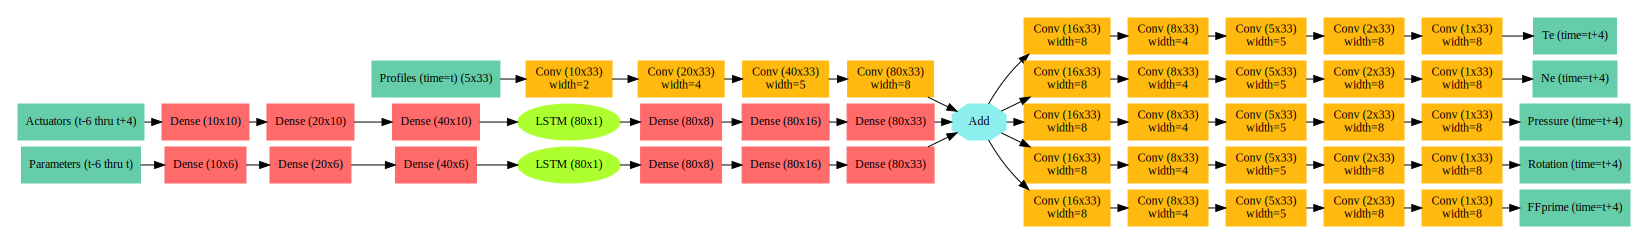

In [4]:
import pydot
from IPython.display import SVG

io_color='mediumaquamarine'
conv_color='darkgoldenrod1'
lstm_color='greenyellow'
dense_color='indianred1'
misc_color='darkslategray2'

conv_shape='box'
dense_shape='box'
lstm_shape='oval'
in_shape='box'
out_shape='box'

fontsize=12

profiles = ['Te', 'Ne', 'Pressure', 'Rotation', 'FFprime']
prof_in_kernels = ['(10x33) \n width=2','(20x33) \n width=4','(40x33) \n width=5','(80x33) \n width=8']
prof_out_kernels = ['(16x33) \n width=8','(8x33) \n width=4','(5x33) \n width=5','(2x33) \n width=8','(1x33) \n width=8']
dense_act_in = ['(10x10)','(20x10)','(40x10)']
dense_act_out = ['(80x8)','(80x16)','(80x33)']
dense_par_in = ['(10x6)','(20x6)','(40x6)']
dense_par_out = ['(80x8)','(80x16)','(80x33)']

graph = pydot.Dot(graph_type='digraph',splines=True, overlap=False,  pad=.25, ranksep=.25, nodesep=.1,rankdir="LR")

nodes = {'profile_input': pydot.Node('profile_input',label="Profiles (time=t) (5x33)", group='prof_input',fontsize=fontsize, shape=in_shape, style="filled", color=io_color),
        'actuator_input':pydot.Node('actuator_input',label="Actuators (t-6 thru t+4)", group='act',fontsize=fontsize, shape=in_shape, style="filled", color=io_color),
        'parameter_input':pydot.Node('parameter_input',label="Parameters (t-6 thru t)", group='par',fontsize=fontsize, shape=in_shape, style="filled", color=io_color),
        'actuator_LSTM':pydot.Node('actuator_LSTM',label="LSTM (80x1)", shape=lstm_shape, group='act',fontsize=fontsize, style="filled", color=lstm_color),
        'parameter_LSTM':pydot.Node('parameter_LSTM',label="LSTM (80x1)", shape=lstm_shape, group='par',fontsize=fontsize, style="filled", color=lstm_color),
        'merge':pydot.Node('merge',label="Add",fontsize=fontsize, shape='octagon', style="filled", color=misc_color),
       }
# actuator, parameter dense
for kernel in dense_act_in+dense_act_out:
    nodes.update({'actuators'+kernel:pydot.Node('actuators'+kernel,label='Dense '+kernel, group='act',fontsize=fontsize, shape=dense_shape,style='filled',color=dense_color)})
for kernel in dense_par_in+dense_par_out:
    nodes.update({'parameters'+kernel:pydot.Node('parameters'+kernel,label='Dense '+kernel, group='par',fontsize=fontsize,shape=dense_shape,style='filled',color=dense_color)})

# initial convolutions
for kernel in prof_in_kernels:
    nodes.update({'in'+kernel: pydot.Node('in'+kernel,label='Conv '+kernel, group='prof_input',fontsize=fontsize, shape=conv_shape,style='filled',color=conv_color)})

# output convolutions
for profile in profiles:
    nodes.update({profile + '_output': pydot.Node(profile+'_output',label=profile+' (time=t+4)',group=profile,fontsize=fontsize, shape=out_shape, style="filled", color=io_color)})
    for kernel in prof_out_kernels:
        nodes.update({profile+kernel: pydot.Node(profile+kernel,label='Conv '+kernel, group=profile,fontsize=fontsize, shape=conv_shape,style='filled',color=conv_color)})

for k,v in nodes.items():
    graph.add_node(v)

# actuators
graph.add_edge(pydot.Edge(nodes['actuator_input'],nodes['actuators'+dense_act_in[0]]))
graph.add_edge(pydot.Edge(nodes['actuators'+dense_act_in[-1]],nodes['actuator_LSTM']))
graph.add_edge(pydot.Edge(nodes['actuator_LSTM'],nodes['actuators'+dense_act_out[0]]))
graph.add_edge(pydot.Edge(nodes['actuators'+dense_act_out[-1]],nodes['merge']))
for start,stop in zip(dense_act_in[:-1],dense_act_in[1:]):
    graph.add_edge(pydot.Edge(nodes['actuators'+start],nodes['actuators'+stop]))
for start,stop in zip(dense_act_out[:-1],dense_act_out[1:]):
    graph.add_edge(pydot.Edge(nodes['actuators'+start],nodes['actuators'+stop]))
    
# parameters
graph.add_edge(pydot.Edge(nodes['parameter_input'],nodes['parameters'+dense_par_in[0]]))
graph.add_edge(pydot.Edge(nodes['parameters'+dense_par_in[-1]],nodes['parameter_LSTM']))
graph.add_edge(pydot.Edge(nodes['parameter_LSTM'],nodes['parameters'+dense_par_out[0]]))
graph.add_edge(pydot.Edge(nodes['parameters'+dense_par_out[-1]],nodes['merge']))
for start,stop in zip(dense_par_in[:-1],dense_par_in[1:]):
    graph.add_edge(pydot.Edge(nodes['parameters'+start],nodes['parameters'+stop]))
for start,stop in zip(dense_par_out[:-1],dense_par_out[1:]):
    graph.add_edge(pydot.Edge(nodes['parameters'+start],nodes['parameters'+stop]))
    
# profile convolutions
for start,stop in zip(prof_in_kernels[:-1],prof_in_kernels[1:]):
    graph.add_edge(pydot.Edge(nodes['in'+start],nodes['in'+stop]))

# output convolutions
for profile in profiles:
    for start, stop in zip(prof_out_kernels[:-1],prof_out_kernels[1:]):
        graph.add_edge(pydot.Edge(nodes[profile+start],nodes[profile+stop]))
    graph.add_edge(pydot.Edge(nodes[profile+prof_out_kernels[-1]],nodes[profile+'_output']))
    graph.add_edge(pydot.Edge(nodes['merge'],nodes[profile+prof_out_kernels[0]]))
    
graph.add_edge(pydot.Edge(nodes['profile_input'],nodes['in'+prof_in_kernels[0]]))
graph.add_edge(pydot.Edge(nodes['in'+prof_in_kernels[-1]],nodes['merge']))




# graph.write_pdf('model_arch.pdf')
SVG(graph.create(prog='dot', format='svg'))


In [38]:
nodes['Te(8x1)']

In [32]:
graph.get_edges()